<a href="https://colab.research.google.com/github/ParthUpah/RISEN_CS367_LAB_CODES/blob/main/lab8_problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

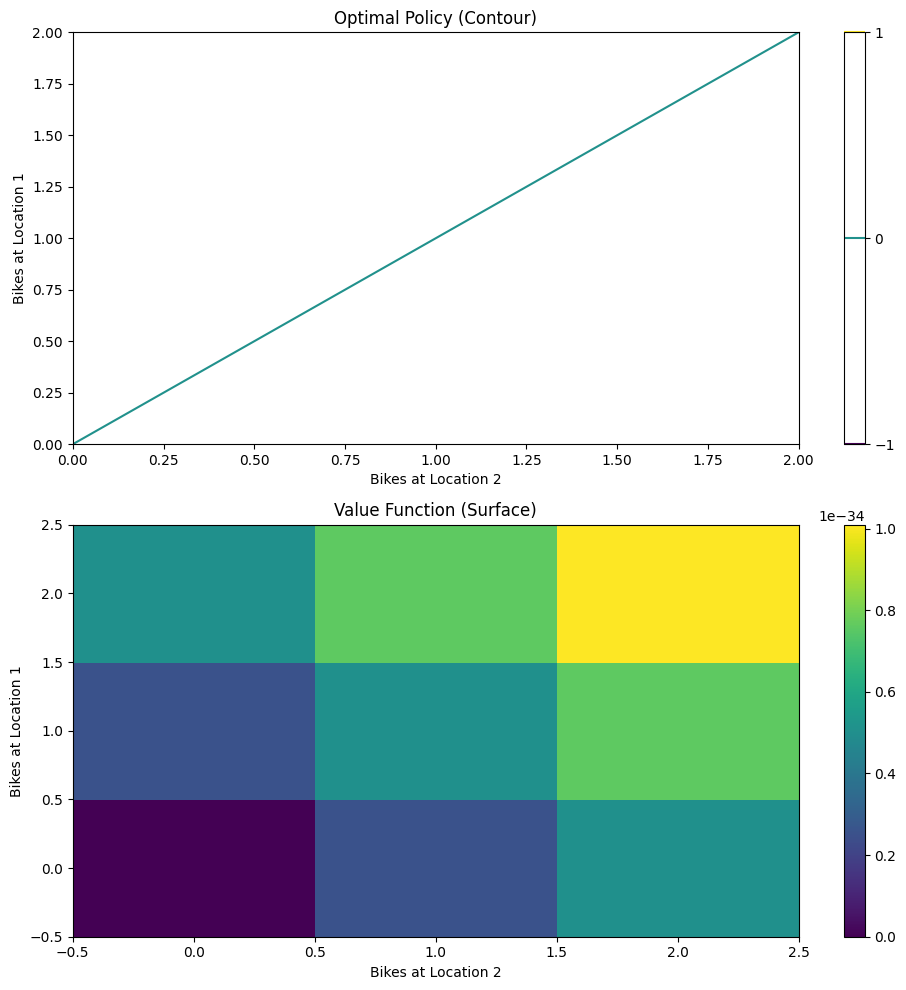

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameters for minimal input
Lamda = [1, 1]  # Expected rental requests (location 1 and 2)
lamda = [1, 1]  # Expected returns (location 1 and 2)
r = 10          # Rental reward
t = 2           # Transfer cost per bike
parking_cost = 4  # Additional parking cost for exceeding 10 bikes
free_transfer = 1  # Free bike transfer from location 1 to location 2
gam = 0.5        # Discount factor (lower for faster convergence)
max_bikes = 2    # Maximum bikes at each location
max_transfer = 1  # Maximum bikes transferred overnight
theta = 1         # Convergence threshold (higher for faster convergence)

# Initialization
policy = np.zeros((max_bikes + 1, max_bikes + 1))  # Initial policy (no transfers)
policy_stable = False  # Convergence flag
count = 0  # Iteration counter

while not policy_stable:
    # Policy Evaluation
    m, n = policy.shape  # State space dimensions
    nn = np.arange(max(15, 13, 10) + 1)

    # Poisson probabilities for requests and returns
    P1 = poisson.pmf(nn, Lamda[0])
    P2 = poisson.pmf(nn, Lamda[1])
    P3 = poisson.pmf(nn, lamda[0])
    P4 = poisson.pmf(nn, lamda[1])

    V = np.zeros((m, n))  # Initialize value function
    delta = 10  # Convergence threshold
    theta = 0.1  # Tolerance for stopping

    while delta > theta:
        v = V.copy()
        for i in range(m):
            for j in range(n):
                s1 = i  # State (number of bikes at location 1)
                s2 = j  # State (number of bikes at location 2)
                a = policy[i, j]  # Action (bikes moved from location 1 to 2)

                # Adjust state based on action
                s1_ = int(s1 - a)
                s2_ = int(s2 + a)
                if s1_ < 0 or s2_ < 0 or s1_ > m - 1 or s2_ > n - 1:
                    continue  # Invalid state

                # Calculate transfer cost (first bike free if moving from 1 to 2)
                transfer_cost = max(0, abs(a) - free_transfer) * t

                # Add parking cost if applicable
                parking_cost_1 = parking_cost * (s1_ > 10)
                parking_cost_2 = parking_cost * (s2_ > 10)
                R = -(transfer_cost + parking_cost_1 + parking_cost_2)  # Immediate costs

                Vs_ = 0
                for n1 in range(13):  # Rental requests at location 1
                    for n2 in range(15):  # Rental requests at location 2
                       s1__ = int(s1_ - min(n1, s1_))  # Ensure integer
                       s2__ = int(s2_ - min(n2, s2_))  # Ensure integer

                    for n3 in range(13):  # Returns at location 1
                            for n4 in range(10):  # Returns at location 2
                                s1___ = int(s1__ + min(n3, m - 1 - s1__))  # Ensure integer
                                s2___ = int(s2__ + min(n4, n - 1 - s2__))  # Ensure integer

                             # Ensure valid indices before accessing V
                if 0 <= s1___ < m and 0 <= s2___ < n:
                    prob = P1[n1] * P2[n2] * P3[n3] * P4[n4]
                    R += prob * (min(n1, s1_) + min(n2, s2_)) * r
                    Vs_ += prob * V[s1___, s2___]  # Use valid indices
                    V[i, j] = R + gam * Vs_

        delta = np.max(np.abs(V - v))  # Check convergence

    # Policy Improvement
    policy_stable = True  # Assume stable until proven otherwise
    old_policy = policy.copy()

    for i in range(m):
        for j in range(n):
            s1 = i  # State (number of bikes at location 1)
            s2 = j  # State (number of bikes at location 2)
            amin = -min(min(s2, m - 1 - s1), max_transfer)  # Minimum valid action
            amax = min(min(s1, n - 1 - s2), max_transfer)  # Maximum valid action
            v_ = -np.inf  # Initialize maximum value

            for a in range(int(amin), int(amax) + 1):
                # Calculate transfer cost (first bike free if moving from 1 to 2)
                transfer_cost = max(0, abs(a) - free_transfer) * t

                # Add parking cost if applicable
                s1_ = s1 - a
                s2_ = s2 + a
                if s1_ < 0 or s2_ < 0 or s1_ > m - 1 or s2_ > n - 1:
                    continue  # Invalid state
                parking_cost_1 = parking_cost * (s1_ > 10)
                parking_cost_2 = parking_cost * (s2_ > 10)
                R = -(transfer_cost + parking_cost_1 + parking_cost_2)  # Immediate costs

                Vs_ = 0
                for n1 in range(13):
                    for n2 in range(15):
                        s1__ = s1_ - min(n1, s1_)
                        s2__ = s2_ - min(n2, s2_)
                        for n3 in range(13):
                            for n4 in range(10):
                                s1___ = s1__ + min(n3, m - 1 - s1__)
                                s2___ = s2__ + min(n4, n - 1 - s2__)

                                prob = P1[n1] * P2[n2] * P3[n3] * P4[n4]
                                R += prob * (min(n1, s1_) + min(n2, s2_)) * r
                                Vs_ += prob * V[s1_, s2_]

                if R + gam * Vs_ > v_:
                    v_ = R + gam * Vs_
                    policy[i, j] = a

    if np.sum(np.abs(old_policy - policy)) != 0:
        policy_stable = False

    count += 1

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Optimal policy plot
c = axs[0].contour(policy, levels=np.arange(-max_transfer, max_transfer + 1))
axs[0].set_title('Optimal Policy (Contour)')
axs[0].set_xlabel('Bikes at Location 2')
axs[0].set_ylabel('Bikes at Location 1')
fig.colorbar(c, ax=axs[0])

# Value function plot
surf = axs[1].imshow(V, cmap='viridis', origin='lower', aspect='auto')
axs[1].set_title('Value Function (Surface)')
axs[1].set_xlabel('Bikes at Location 2')
axs[1].set_ylabel('Bikes at Location 1')
fig.colorbar(surf, ax=axs[1])

plt.tight_layout()
plt.show()